In [1]:
import re
from pprint import pprint

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from gensim.models import KeyedVectors, Word2Vec
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity


pd.set_option('display.max_colwidth', None)
SPECIAL_CHARS = '[^A-Za-z0-9 ]+'
STOP_WORDS = stopwords.words('english')

# 2. Functions

In [2]:
def preprocess_text(text):
    """
    Take out stopwords.
    Take out punctuations and special characters.
    """
    SPECIAL_CHARS = '[^A-Za-z0-9 ]+'
    STOP_WORDS = stopwords.words('english')
    text = text.lower().split(' ')
    temp = [word for word in text if word not in STOP_WORDS]
    text = ' '.join(temp)
    text = re.sub(SPECIAL_CHARS, '', text)
    return text

In [3]:
def tokenise(doc):
    return [token.text for token in nlp(doc)]

In [4]:
def tokenise_lemma(doc):
    """
    Use spacy as the nlp object to tokenise each doc
    Lemmatise each words
    """
    return ' '.join([token.lemma_ for token in nlp(doc)])

In [5]:
# this is one way to get each title's vector representation
# more investagtion is needed later.

def get_vectors(first_map, second_map):
    """
    Use tokenised words to get vectors representations from the pretrained model (i.e. second_map).
    Average the vector representation of the description as the representation of the document 
    (i.e. each movie title's representation is the mean of vectors of each words in its description)
    """
    first_vec  = dict()
    for title, description in first_map.items():
        temp = list()
        for element in description: #element = tokenised words
            try:
                temp.append(second_map[element]) #secondmap is w2v model which should have a responding word vecotr for the tokenise word
            except KeyError:
                pass
        first_vec[title] = np.mean(temp, axis=0)
    
    return first_vec

In [6]:
def search(name, df):
    return df.loc[df['title'].str.lower()==name.lower()]

In [31]:
def get_topN_similar(lookup_id, title_vec, df, N=10):
    lookup_id = lookup_id.lower()
    sim = list()
    lookup_map = title_vec
    subject_map = title_vec 
        
    for uid, vec in lookup_map.items():
        thisSim = cosine_similarity(vec.reshape(1, -1), subject_map[lookup_id].reshape(1, -1))
        org = search(uid, df).originals.values
        gen = search(uid, df).genres.values
        sim.append((uid, thisSim[0][0], org, gen))
    sim = sorted(sim, key=lambda x: x[1], reverse=True)[:N+1]
    returnDf = pd.DataFrame(columns=['title','similarity','originals','genres'],
                           data = sim)
    return returnDf

In [8]:
def get_most_similar(lookup_id, title_vec, df):

    sim = list()
    lookup_map = title_vec
    subject_map = title_vec 
        
    for uid, vec in lookup_map.items():
        thisSim = cosine_similarity(vec.reshape(1, -1), subject_map[lookup_id].reshape(1, -1))
        org = search(uid, df).originals.values
        gen = search(uid, df).genres.values
        sim.append((uid, thisSim[0][0], org, gen))

    return sorted(sim, key=lambda x: x[1], reverse=True)

In [9]:
def filter_df(keyword):
    """
    Return a dataframe with the filtered result.
    The input value is case-insensitive. 
    """
    if type(keyword) == list:
        return netflixDf.loc[netflixDf['title'].isin(keyword)]
    else:
        return netflixDf.loc[netflixDf['title'].str.lower().isin([keyword.lower()])]

In [10]:
def markerX(key, values):
    return netflixDf.loc[netflixDf[key].str.lower().isin(values)].sort_values(by='pca_2', ascending=False)

def others(key, values):
    return netflixDf.loc[~netflixDf[key].str.lower().isin(values)]

# 3. Analyse Pipeline

## Terms explained
Document -> a bunch of texts <br>
Corpus -> a bunch of documents <br>
Vectors -> a mathematically convenience representation of a document (a bunch of textx) <br>
Models -> an algorithm for transforming vectors from one representation to another <br>

## Read the dataset/ Load the spacy pretrained model

In [87]:
netflixDf = pd.read_csv('finalDataset_v2.csv', usecols=['title','type','description','genres','originals', 'year'])

In [88]:
df = pd.read_csv('debugged.csv', usecols=['cleaned'])

In [89]:
netflixDf = pd.concat([netflixDf,df], axis=1)

In [14]:
# np.where(pd.isnull(df.cleaned))

In [15]:
# use pre-trained corpus to help tokenise words
nlp = spacy.load('en_core_web_sm')

## Analyse Descriptive Data

In [63]:
movieDf = netflixDf.loc[netflixDf['type']=='movie']
tvshowDf = netflixDf.loc[netflixDf['type']=='tvshow']

## Create Corpus and apply word embedding

In [64]:
movieCorpus = movieDf.cleaned.values.tolist() #list of docs
tvshowCorpus = tvshowDf.cleaned.values.tolist() #list of docs

In [65]:
movieTkDocs = [tokenise(doc) for doc in movieCorpus] #tokenise 
tvshowTkDocs = [tokenise(doc) for doc in tvshowCorpus] #tokenise 

In [66]:
# mapping out the title and each description. so later on i can search 
movieMap = dict(zip(movieDf['title'].str.lower().tolist(), movieTkDocs))
tvshowMap = dict(zip(tvshowDf['title'].str.lower().tolist(), tvshowTkDocs))
# lower the title (easy for search)

In [21]:
path = "GoogleNews-vectors-negative300.bin"
w2v = KeyedVectors.load_word2vec_format(path, binary=True)
# It is much faster take less than 2 minutes

In [67]:
movieTitleVec = get_vectors(movieMap, w2v)

In [68]:
tvshowTitleVec = get_vectors(tvshowMap, w2v)

In [26]:
get_topN_similar('you', tvshowTitleVec, tvshowDf)

,title,similarity,originals,genres
0,you,1.000000,[0],"[crime,drama,romance,thriller]"
1,man down,0.851182,[0],[comedy]
2,sword art online alternative: gun gale online,0.850906,[0],"[animation,anime,action-and-adventure,fantasy,science-fiction]"
3,love alarm,0.843957,[1],"[drama,comedy,romance]"
4,the mysteries of laura,0.832644,[0],"[comedy,crime,drama,mystery]"
5,"love, chunibyo & other delusions",0.832444,[0],"[animation,anime,comedy,drama,romance,fantasy]"
6,no tomorrow,0.828042,[0],"[drama,comedy,romance]"
7,the good place,0.827645,[0],"[comedy,drama,fantasy,romance,science-fiction]"
8,london spy,0.825912,[0],"[drama,lgbtq,crime,mystery,romance,thriller]"
9,servant of the people,0.825141,[0],[comedy]


In [69]:
search('splatter',movieDf)

,title,genres,description,type,originals,cleaned
2819,Splatter,"horror,drama",https://www.themoviedb.org/tv/39633-splatterSplatter is streaming with subscription on Netflix. It's a drama and horror movie with a very low IMDb audience rating of 3.1 (456 votes).,movie,0,"Johnny Splatter accumulated as many hit records as he did enemies on his climb up the fame ladder. His sudden death, ruled a suicide, brings a small circle of professional parasites and hangers-on to his Hollywood Hills mansion for the reading of his last will and testament. But as his “frenemies” come to pick the bones clean, Johnny has returned for a deadly encore long after what they thought was his final curtain."


In [70]:
x = movieTitleVec['splatter']
y = movieTitleVec['tall girl']
cosine_similarity(x.reshape(1, -1), y.reshape(1, -1))

array([[0.79452443]], dtype=float32)

In [398]:
def get_topN_similar(lookup_id, title_vec, df, N=10):
    lookup_id = lookup_id.lower()
    sim = list()
    lookup_map = title_vec
    subject_map = title_vec 
        
    for uid, vec in lookup_map.items():
        try:
            thisSim = cosine_similarity(vec.reshape(1, -1), subject_map[lookup_id].reshape(1, -1))
            org = search(uid, df).originals.values
            gen = search(uid, df).genres.values
            sim.append((uid, thisSim[0][0], org, gen))
        except:
            print(uid)
    sim = sorted(sim, key=lambda x: x[1], reverse=True)[:N+2]
    returnDf = pd.DataFrame(columns=['title','similarity','originals','genres'],
                           data = sim)
    return returnDf

In [72]:
get_topN_similar('The Perfect Date', movieTitleVec, movieDf)

,title,similarity,originals,genres
0,the perfect date,1.000000,[1],"[romance,comedy]"
1,my birthday song,0.788607,[0],[thriller]
2,swiped,0.783935,[0],"[comedy,romance,drama]"
3,social animals,0.780966,[0],"[documentary,comedy,romance]"
4,yes or no,0.780705,[0],"[comedy,romance]"
5,kaake da viyah,0.777043,[0],"[comedy,romance]"
6,kicking and screaming,0.777026,[0],"[comedy,drama,romance]"
7,68 kill,0.776625,[0],"[comedy,romance,thriller,crime,mystery]"
8,can't hardly wait,0.776468,[0],"[comedy,romance,drama]"
9,french dirty,0.775756,[0],"[comedy,drama]"


In [150]:
get_topN_similar('The Perfect Date', movieTitleVec, mvevt)

,title,similarity,originals,genres
0,the perfect date,1.000000,[1],"[romance,comedy]"
1,swiped,0.821608,[0],"[comedy,romance,drama]"
2,yes or no,0.810153,[0],"[comedy,romance]"
3,lady-like,0.809170,[0],"[comedy,romance]"
4,can't hardly wait,0.807135,[0],"[comedy,romance,drama]"
5,social animals,0.806844,[0],"[documentary,comedy,romance]"
6,#friendbutmarried,0.805303,[0],"[biography,drama,romance,comedy]"
7,68 kill,0.802554,[0],"[comedy,romance,thriller,crime,mystery]"
8,the new romantic,0.801927,[0],"[drama,comedy,romance]"
9,yes or no 2.5,0.800287,[0],"[romance,comedy]"


In [54]:
for key, value in movieTitleVec.items():
    if np.isfinite(value.all()) == False:
        print(key)

## What if I include genre information

In [123]:
movieDf_gen = netflixDf.loc[netflixDf['type']=='movie'].copy()

In [90]:
# netflixDf['genres'].fillna('No info', inplace=True)

In [109]:
y = []
for i in netflixDf.year.values.tolist():
    if len(i)==4:
        y.append(i)
    else:
        y.append('No info')

In [112]:
netflixDf['year'] = y

In [114]:
# netflixDf.to_csv('finaldataset_v3.csv')

In [131]:
temp = pd.read_csv('finaldataset_v3.csv', usecols=['title','genres','year','type','originals','cleaned'])
mvevt = temp.loc[temp['type']=='movie'].copy()

In [132]:
mvevt.head(1)

,title,genres,year,type,originals,cleaned
0,1000 Mabrouk,"comedy,drama,fantasy,thriller",2009,movie,0,"About a man who wakes up one morning to discover that the day repeats, a carbon copy of the day before, trapping him in an inescapable vicious circle. This man has a dream to live for 100 years, however he is living for one day only and that day keep repeating to show him the negative and positive things in his life."


In [135]:
mvevt['genres'].isnull().sum()

0

In [138]:
everything = list()
for ix in range(3770):
    everything.append(mvevt.iloc[ix,5]+ ' ' +mvevt.iloc[ix,1])
    

In [139]:
everything[0]

'About a man who wakes up one morning to discover that the day repeats, a carbon copy of the day before, trapping him in an inescapable vicious circle. This man has a dream to live for 100 years, however he is living for one day only and that day keep repeating to show him the negative and positive things in his life. comedy,drama,fantasy,thriller'

In [140]:
mvevt['everything'] = everything

In [144]:
mvevtTkDocs = [tokenise(doc) for doc in mvevt.everything.values.tolist()] #tokenise 

In [145]:
# mapping out the title and each description. so later on i can search 
movieMap = dict(zip(mvevt['title'].str.lower().tolist(), mvevtTkDocs))
# lower the title (easy for search)

In [146]:
movieTitleVec = get_vectors(movieMap, w2v)

In [399]:
get_topN_similar('tall girl', movieTitleVec, mvevt)

,title,similarity,originals,genres
0,tall girl,1.000000,[1],"[comedy,drama,romance]"
1,laggies,0.889598,[0],"[comedy,romance,drama]"
2,love is blind,0.888021,[1],"[comedy,drama,romance]"
3,social animals,0.873785,[0],"[documentary,comedy,romance]"
4,ugly aur pagli,0.872610,[0],"[comedy,drama,romance]"
5,next enti?,0.871522,[0],"[comedy,drama,romance]"
6,deliha 2,0.867681,[0],[comedy]
7,isoken,0.867054,[0],[romance]
8,rainbow time,0.864650,[0],"[comedy,drama]"
9,jessica darling's it list,0.864558,[0],[family]


In [397]:
search('social animals',movieDf)

,title,genres,description,type,originals,cleaned
2778,Social Animals,"documentary,comedy,romance","Determined not to turn into her parents, or be drawn into any relationship longer than a one night stand, Zoe constantly struggles with her failing business and love life. Then she falls in love for the first time with Paul. But there's one problem: Paul is married.Social Animals featuring Noël Wells and Josh Radnor is streaming with subscription on Netflix, streaming on CBS All Access, available for rent or purchase on iTunes, and 3 others. It's a comedy and documentary movie with a low Rotten Tomatoes (critics) score of 38% and a less than average IMDb audience rating of 5.2 (1,522 votes).",movie,0,"Determined not to turn into her parents, or be drawn into any relationship longer than a one night stand, Zoe constantly struggles with her failing business and love life. Then she falls in love for the first time with Paul. But there's one problem: Paul is married."


In [400]:
get_topN_similar('bird box', movieTitleVec, mvevt)

,title,similarity,originals,genres
0,bird box,1.000000,[1],"[thriller,drama,science-fiction,mystery,horror]"
1,the silence_2019,0.852333,[0],"[horror,drama,science-fiction,thriller,mystery,fantasy,comedy]"
2,dark places,0.845272,[0],"[drama,mystery,thriller,action-and-adventure]"
3,the forest of love,0.837695,[1],"[drama,mystery,horror,thriller,crime]"
4,the keeping hours,0.835456,[0],"[thriller,drama,fantasy,horror,mystery]"
5,how it ends,0.833911,[1],"[action-and-adventure,science-fiction,thriller,mystery,drama]"
6,cabin fever,0.833048,[0],"[comedy,horror,science-fiction,thriller,mystery]"
7,our house,0.832478,[0],"[drama,horror,mystery,science-fiction,thriller]"
8,mute,0.830375,[1],"[drama,mystery,science-fiction,thriller]"
9,into the forest,0.829294,[0],"[drama,science-fiction,thriller,mystery,horror]"


In [402]:
search('mute', movieDf)

,title,genres,description,type,originals,cleaned
2115,Mute,"drama,mystery,science-fiction,thriller","A mute man with a violent past is forced to take on the teeming underworld of a near-future Berlin as he searches for his missing girlfriend.Mute featuring Alexander Skarsgård and Paul Rudd is streaming with subscription on Netflix, and streaming with subscription on Prime Video. It's a drama and mystery movie with a very low Rotten Tomatoes (critics) score of 20% and a less than average IMDb audience rating of 5.4 (29,082 votes).",movie,1,A mute man with a violent past is forced to take on the teeming underworld of a near-future Berlin as he searches for his missing girlfriend.


## It is clear that adding genres into corpus improves accuracy

# Descriptive analysis

In [151]:
# genres count
mv = temp.loc[temp['type']=='movie'].copy()

In [158]:
from collections import defaultdict

In [370]:
def count_genres(genre_list):
    """
    genre_list is pd sereis
    return a dataframe
    """
    genres_count = defaultdict(int)
    for movie in genre_list:
        for genre in movie.split(','):
            genres_count[genre] += 1
    df = pd.DataFrame(data=[genres_count])
    df = df.transpose().reset_index().rename(columns={'index':'genres',0:'counts'}).sort_values(by = 'counts', ascending=False).reset_index(drop=True)
    df['percentage'] = df['counts'].apply(lambda x: round(x/df.counts.sum(),2))
    return df

In [237]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left", va='bottom')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [268]:
mv_genres_count = count_genres(mv.genres.values.tolist())

In [245]:
mv_org = mv.loc[mv['originals']==1].copy()

In [251]:
mv_org_genres_count = count_genres(mv_org.genres.values.tolist())

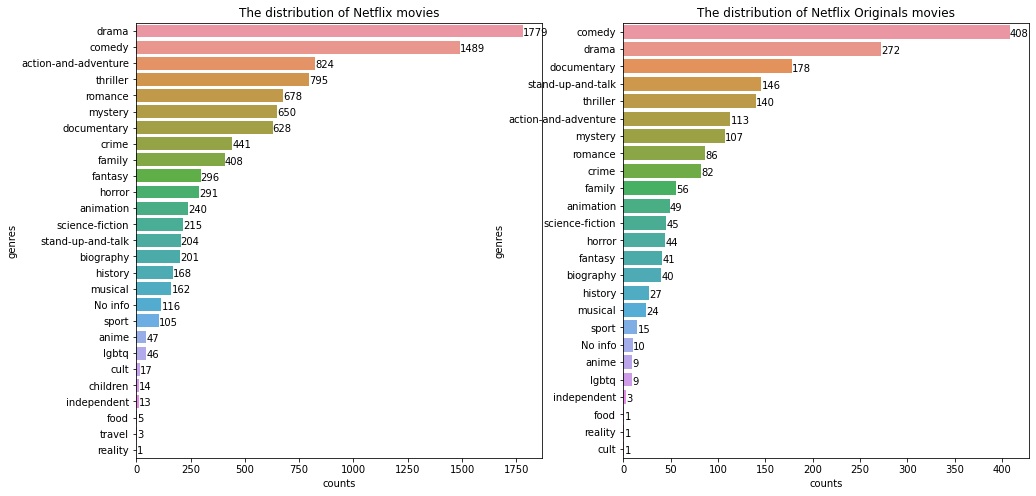

In [269]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
bar = sns.barplot(x = 'counts',
                  y = 'genres',
                  data = mv_genres_count,
                  ax = ax[0],
                  orient = 'h')
show_values_on_bars(bar, h_v='h', space=0.3)
ax[0].set_title('The distribution of Netflix movies')

bar = sns.barplot(x = 'counts',
                  y = 'genres',
                  data = mv_org_genres_count,
                  ax = ax[1],
                  orient = 'h')
show_values_on_bars(bar, h_v='h', space=0.3)
ax[1].set_title('The distribution of Netflix Originals movies')
plt.show()

Nomalise the data and compare

In [270]:
mv_genres_count['percentage'] = mv_genres_count['counts'].apply(lambda x: round(x/genres_df.counts.sum(),2))
mv_org_genres_count['percentage'] = mv_org_genres_count['counts'].apply(lambda x: round(x/genres_df.counts.sum(),2))

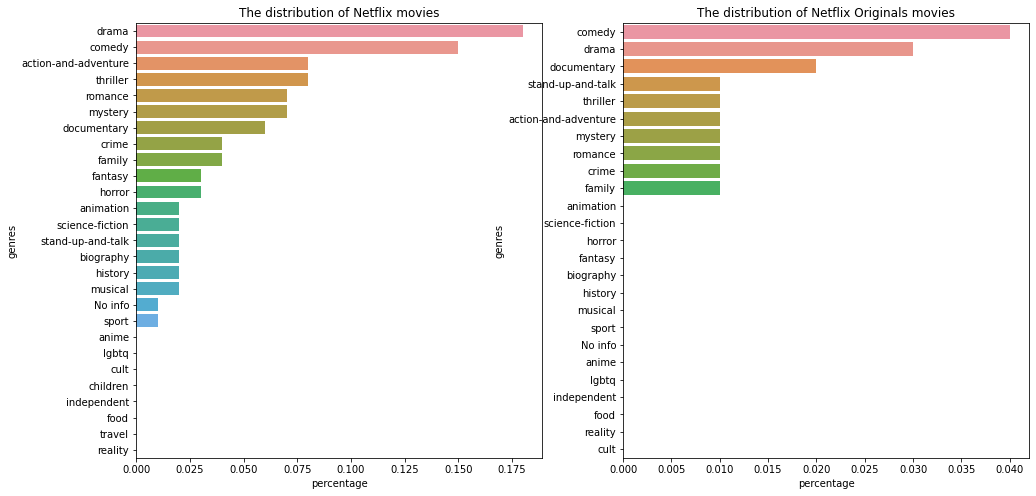

In [390]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
bar = sns.barplot(x = 'percentage',
                  y = 'genres',
                  data = mv_genres_count,
                  ax = ax[0],
                  orient = 'h')
# show_values_on_bars(bar, h_v='h', space=0.3)
ax[0].set_title('The distribution of Netflix movies')

bar = sns.barplot(x = 'percentage',
                  y = 'genres',
                  data = mv_org_genres_count,
                  ax = ax[1],
                  orient = 'h')
# show_values_on_bars(bar, h_v='h', space=0.3)
ax[1].set_title('The distribution of Netflix Originals movies')
plt.savefig('movie%.png')
plt.show()

In [289]:
def trend_in_yearN(df ,genre , N):
    """
    return how many title's are in the given genre in the given year.
    """
    x = count_genres(df.loc[df['year']== N].genres.values.tolist())
    return x.set_index('genres').loc[genre].values.tolist()[0]

In [313]:
def ten_year_trend(df, genre, s=2010, e=2020):
    """
    default setting start with 2010 end with 2019 (10 years).
    return a dictionary
    """
    trend = defaultdict(int)
    for key in range(s, e):
        year = str(key)
        trend[key] = trend_in_yearN(mv, genre, year)
    return trend

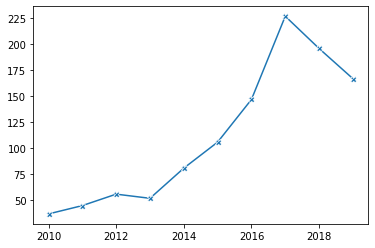

In [315]:
com = ten_year_trend(mv, 'comedy')
sns.lineplot(x = list(com.keys()),
            y = list(com.values()),
            marker = 'X')

In [363]:
def create_trend_dataframe(df, cols):
    """
    df = from which df to produce ten_year_trend
    cols = list of genres you want to include
    """
    trend_df = pd.DataFrame()
    for genre in cols:
        temp = pd.DataFrame(data=[ten_year_trend(df, genre)]).transpose().rename(columns={0:genre})
        trend_df = pd.concat([trend_df, temp], axis=1)
    return trend_df

In [361]:
cols = ['drama','comedy','action-and-adventure','thriller','romance',
        'mystery', 'documentary','crime','family','fantasy']
trend_df = pd.DataFrame()
for genre in cols:
    temp = pd.DataFrame(data=[ten_year_trend(mv, genre)]).transpose().rename(columns={0:genre})
    trend_df = pd.concat([trend_df, temp], axis=1)

In [ ]:
create_trend_dataframe(mv, cols)

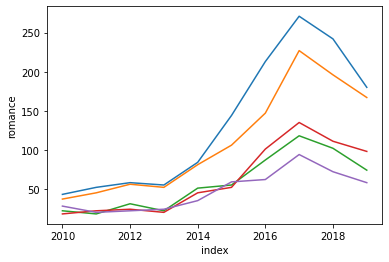

In [360]:
genres = trend_df.columns.values.tolist()[1:6]
for gen in genres:
    sns.lineplot(x = 'index', y = gen, data = trend_df)

## TVshow

In [366]:
temp = pd.read_csv('finaldataset_v3.csv', usecols=['title','genres','year','type','originals','cleaned'])
tv = temp.loc[temp['type']=='tvshow'].copy()

In [371]:
tv_genres_count = count_genres(tv.genres.values.tolist())

In [372]:
tv_org = tv.loc[tv['originals']==1].copy()
tv_org_genres_count = count_genres(tv_org.genres.values.tolist())

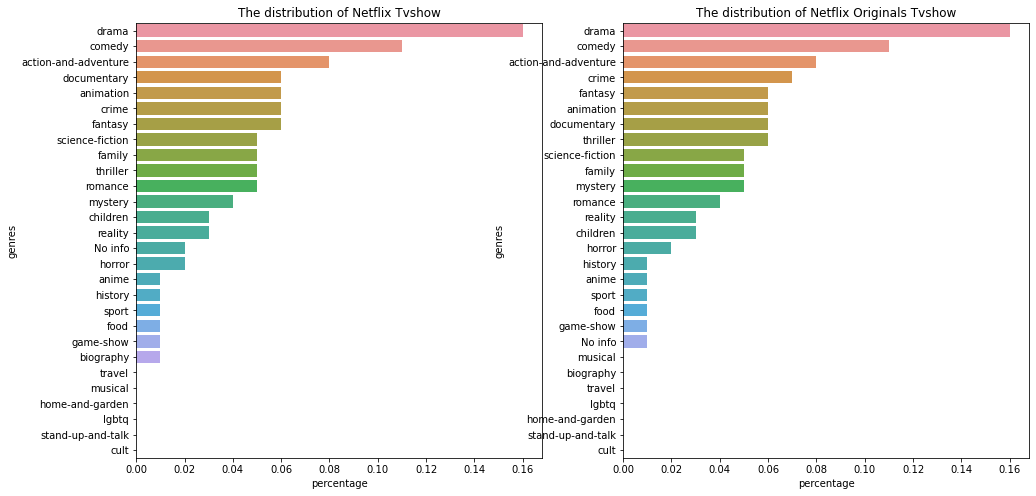

In [391]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
bar = sns.barplot(x = 'percentage',
                  y = 'genres',
                  data = tv_genres_count,
                  ax = ax[0],
                  orient = 'h')
# show_values_on_bars(bar, h_v='h', space=0.3)
ax[0].set_title('The distribution of Netflix Tvshow')

bar = sns.barplot(x = 'percentage',
                  y = 'genres',
                  data = tv_org_genres_count,
                  ax = ax[1],
                  orient = 'h')
# show_values_on_bars(bar, h_v='h', space=0.3)
ax[1].set_title('The distribution of Netflix Originals Tvshow')
plt.savefig('tvshow%.png')
plt.show()

In [381]:
tv_trend = create_trend_dataframe(tv, cols).reset_index()

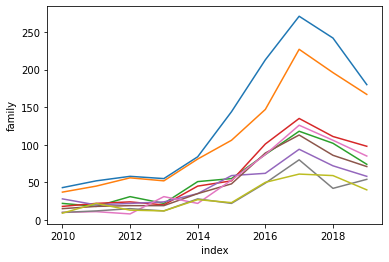

In [383]:
genres = tv_trend.columns.values.tolist()[1:10]
for gen in genres:
    sns.lineplot(x = 'index', y = gen, data = tv_trend)